<a href="https://colab.research.google.com/github/bbachonko/other/blob/main/BCL_Task_analysis_time_series_analysis_Bachonko.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Import danych

In [2]:
import pandas as pd
import numpy as np

In [3]:
url = "https://www.bitpeak.pl/datasets/BCL_TaskCreation.csv"

df_raw = pd.read_csv('https://www.bitpeak.pl/datasets/BCL_TaskCreation.csv', sep=';')
df = df_raw.copy()
df.head()


,dataStream,rowCount,probingTimestamp
0,BCL_TaskCreation,315349655,2020-01-13 09:33:00.497
1,BCL_TaskCreation,315349655,2020-01-13 09:34:00.157
2,BCL_TaskCreation,314533770,2020-01-11 01:18:00.143
3,BCL_TaskCreation,289249872,2020-04-05 16:10:00.333
4,BCL_TaskCreation,289249872,2020-04-05 16:11:00.883


#Wstępne informacje o ramce danych

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 160735 entries, 0 to 160734
Data columns (total 3 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   dataStream        160735 non-null  object
 1   rowCount          160735 non-null  int64 
 2   probingTimestamp  160735 non-null  object
dtypes: int64(1), object(2)
memory usage: 3.7+ MB


Po załadowaniu i wyświetleniu pierwszych rekordów ramki widoczne są 3 kolumny. Serie w ramce przyjmują zarówno wartości numeryczne (*rowCount*) jak i kategoryczne (*dataStream*). Kolumna *dataStream* wydaje się przyjmować tylko jedną wartość. 

In [ ]:
df['dataStream'].unique()

array(['BCL_TaskCreation'], dtype=object)

Jak widać tak też jest. Zmieniamy typ danych ostatniej kolumny z *object* na *datetime* w celu możliwości późniejszej analizy danych

In [ ]:
df['probingTimestamp'] = df.probingTimestamp.astype('datetime64[ns]')

Kolumna rowCount zawiera dane typu numerycznego - wyświetlamy jej podstawe statystyki.

In [ ]:
df.describe()

,rowCount
count,1.607350e+05
mean,3.080677e+08
std,1.973004e+07
min,2.832401e+08
25%,2.893886e+08
50%,3.140155e+08
75%,3.276823e+08
max,3.388414e+08


Ze statystyk nie wynika nic szczególnego (albo wartości są po prostu zbyt duże do intuicyjnej analizy). Jeśli uzyskanie bardziej czytelnych statystyk dot. tej kolumny byłoby dla nas bardzo ważne, możliwe by było np. znormalizowanie jej.
Sprawdźmy, czy istnieją zduplikowane rekordy.

In [ ]:
df.duplicated().value_counts()

False    160513
True        222
dtype: int64

Jak widać istnieje niewielka liczba zduplikowanych rekordów.
Sprawdzamy, czy w ramce występują braki danych. Tę informację można było już wywnioskować przy użyciu metody *info*, jednak użyjemy 'czytelniejszego' sposobu.

In [ ]:
for col in df:
  print(df[col].isnull().value_counts())

False    160735
Name: dataStream, dtype: int64
False    160735
Name: rowCount, dtype: int64
False    160735
Name: probingTimestamp, dtype: int64


Jak widać dla każdej z kolumn zwrócone zostały same wartości *false*, co oznacza, że dane nie zawierają żadnych braków.

Spójrzmy jeszcze raz na parę rekordów z 2 ostatnich kolumn.

In [ ]:
df[['rowCount', 'probingTimestamp']].head(10)

,rowCount,probingTimestamp
0,315349655,2020-01-13 09:33:00.497
1,315349655,2020-01-13 09:34:00.157
2,314533770,2020-01-11 01:18:00.143
3,289249872,2020-04-05 16:10:00.333
4,289249872,2020-04-05 16:11:00.883
5,289249872,2020-04-05 16:12:00.347
6,314533770,2020-01-11 01:19:00.687
7,314533770,2020-01-11 01:20:00.243
8,314533770,2020-01-11 01:21:00.723
9,314533770,2020-01-11 01:22:00.213


Na wyświetlonym wyżej wycinku ramki wydawać się może jakoby wartości w kolumnie *rowCount* były takie same dla kolejnych dni. 

W celu zwiększenia czytelności danych dokonamy ekstrakcji dnia oraz miasiąca z dat. Przypuszczać można, że rok pozostaje niezmienny.

In [ ]:
df.probingTimestamp.dt.year.value_counts()

2020    160735
Name: probingTimestamp, dtype: int64

Jak widać rekordy dotyczą tylko roku 2020. Nie będziemy więc brać go pod uwagę przy tworzeniu dodatkowych kolumn.

In [ ]:
df['day'] = df.probingTimestamp.dt.day
df['month'] = df.probingTimestamp.dt.month


Po ekstrakcji dnaych z kolumn z datą grupujemy względem miesiąca dnia oraz *rowCount* w celu sprawdzenia, czy wartości te rzeczywiście opisują siebie jednoznacznie.

In [ ]:
df.groupby(['month', 'day'])['rowCount'].value_counts()

month  day  rowCount 
1      10   314015548    288
            314477887     68
            314386014     60
            314404276     58
            314423147     58
                        ... 
5      2    289702864     60
            289702883     60
            289702943     60
            289702632     59
            289702490      1
Name: rowCount, Length: 6723, dtype: int64

Wartość *rowCount* występuje wielkrotnie dla pojedynczych dni - przypuszczenie było więc błędne.

Najlepszym sposobem na zobaczenie korelacji pomiędzy tymi kolumnami będzie wykres np. rozproszony.

#Analiza serii czasowej (kol. *probingTimestamp*)

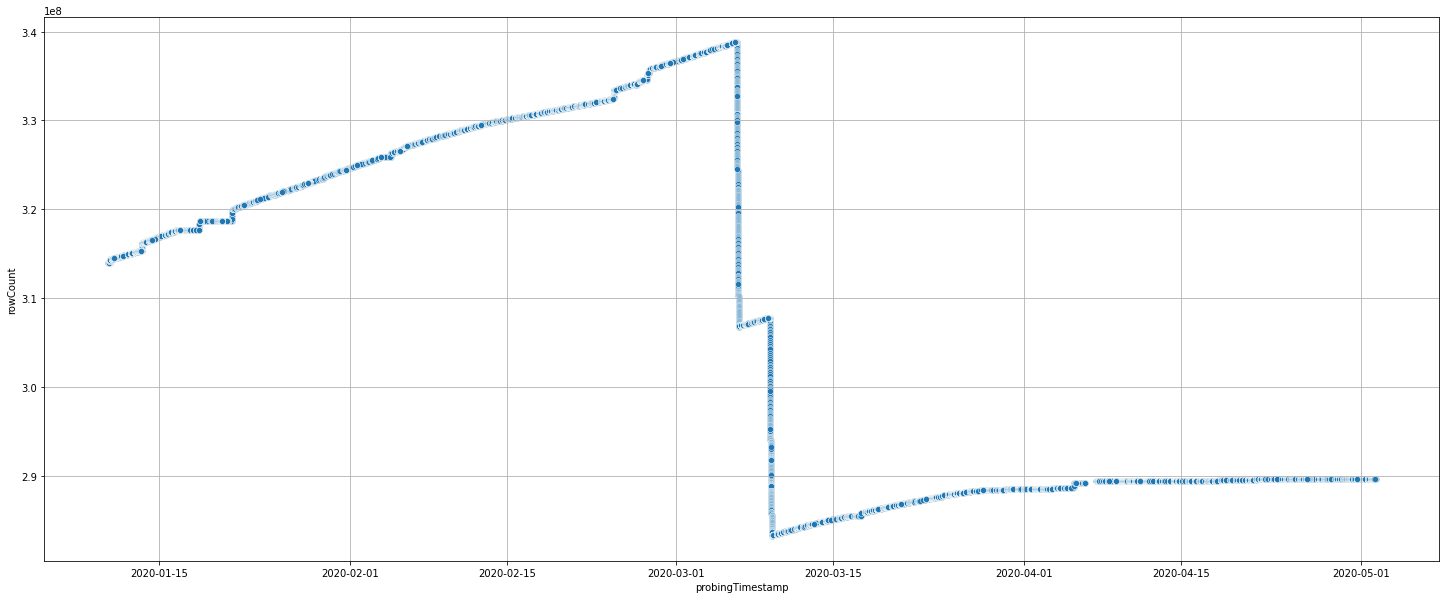

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize = (25,10))
g = sns.scatterplot(x=df.probingTimestamp, y='rowCount', data=df)#.set(yscale='log')
plt.grid()


###Wnioski:
*  Na pewnych odcinkach czasowych widać ciągłość w jednolitym trendzie (mniej więcej liniowym). Tak się dzieje aż do rekordów w połowie marca, po czym znów widać wzrost 'liniowy', zaś na samym końcu przyjmują one stałe wartości
* Nie są zauważalne żadne wartości odstające tzw.outliers co mogłoby świadczyć o niepełności danych/ błędnych rekordach
* zasadniczo ciągłość w serii czasowej jest zachowana (w pierwszej połowie kwietnia dostrzegalna jest drobna przerwa w występowaniu punktów)

Ponadto ramka danych nie była domyślnie uporządkowana względem serii czasowej. 

Teraz zmieniamy zakres naszej serii czasowej w celu lepszego przedstawienia interwału, w którym to nastąpiły największe zmiany w przebiegu wykresu. Przyjrzyjmy się dokładniej temu odcinkowi serii czasowej.

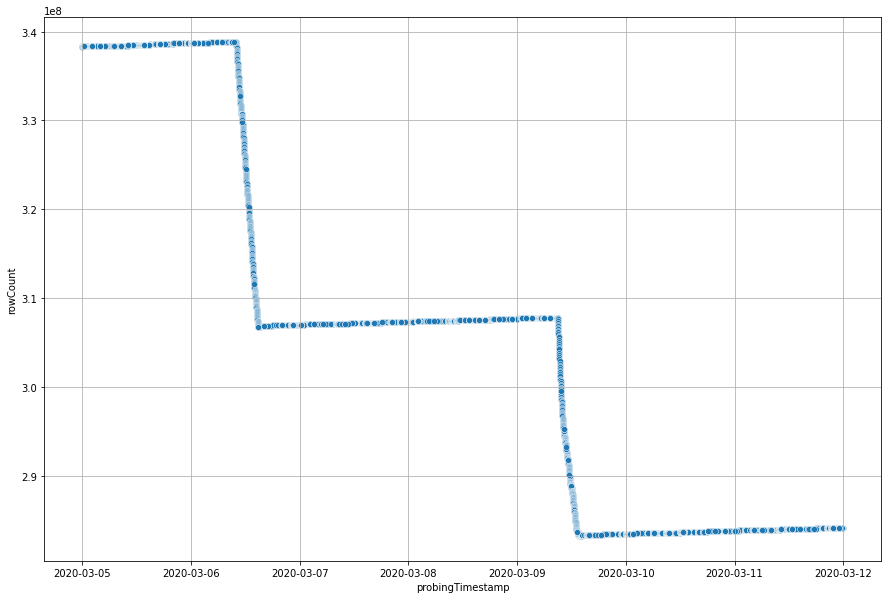

In [ ]:
# tworze przedział czasu dla dnaych, które będę wyświetlał
chosen_period = df.loc[(df['month'] == 3) & (df.day.between(5, 11))]

plt.figure(figsize = (15,10))

g = sns.scatterplot(x=chosen_period.probingTimestamp, y='rowCount', data=df)
plt.grid()

Jak możemy zauważyć wartości kolumny *rowCount* w pewnych momentach gwałtownie zmieniają swój trend (na taki o dużym tangensie nachylenia), po czym po pewnym czasie staje się on ponownie wypłaszczony. Zmiany te nie były poprzedzone żadnym nietypowym zachowniem w rekordach *rowCount*. Zauważalny jest też podobny czas trwania gwałtownego trendu spadkowego w kolumnie dla dwóch ukazanych interwałów, w których to one nastąpiły. Trwają one mniej więcej przez 1/3 dnia.

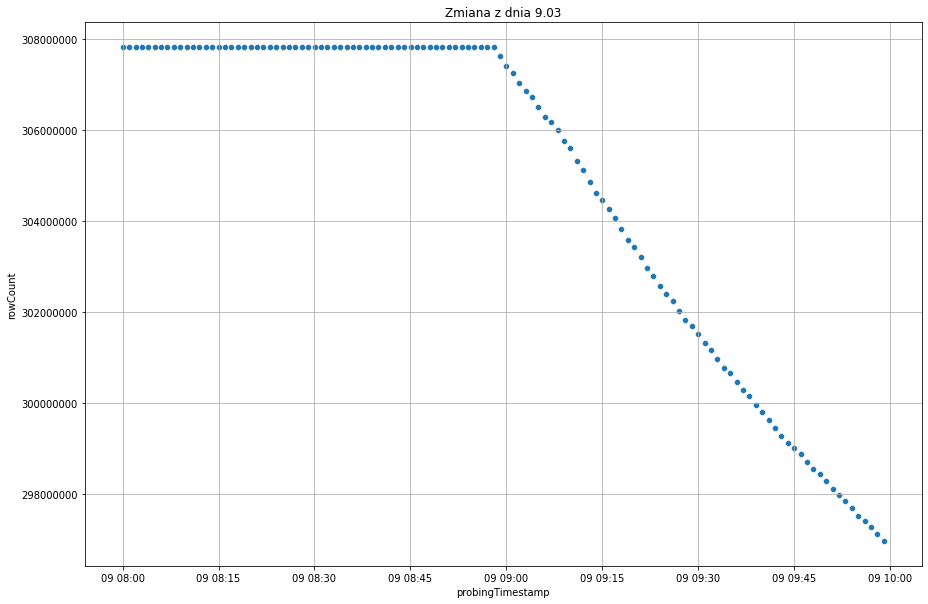

In [ ]:
chosen_period = df.loc[(df['month'] == 3) & (df.day.between(9, 9)) & (df.probingTimestamp.dt.hour.between(8, 9))]


plt.figure(figsize = (15,10))
plt.ticklabel_format(style='plain', axis='y')
g = sns.scatterplot(x=chosen_period.probingTimestamp, y='rowCount', data=df).set(title='Zmiana z dnia 9.03')
plt.grid()

Spójrzmy jeszcze na wykres w mniejszym zakresie *probingTimeseries*. Widoczne jest bardzo równomierne rozłożenie punktów względem osi czasu. Od momentu spadku wartości kolumny rowCount jej zmiana w funkcji serii czasowej utrzymywała się także na dośc stałym poziomie. Na wykresie wyłączono zapis naukowy w celu lepszego zobrazowania zależności na przedstawionym wycinku serii czasowej.

Przyjrzyjmy się dokładniej wspomnianemu odcinkowi serii, w którym możemy obserwować przerwanie ciągłości w danych.

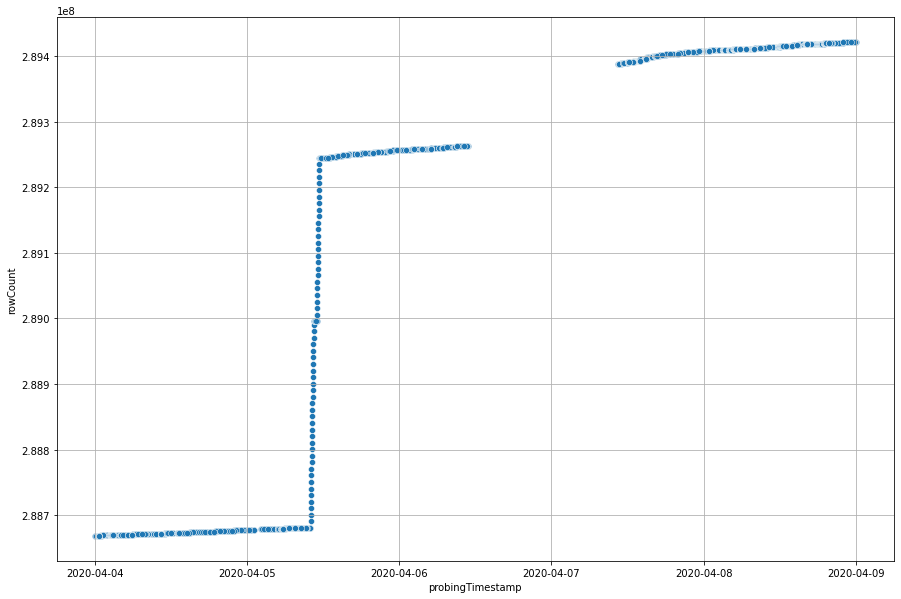

In [ ]:
chosen_period = df.loc[(df['month'] == 4) & (df.day.between(4, 8))]

plt.figure(figsize = (15,10))

g = sns.scatterplot(x=chosen_period.probingTimestamp, y='rowCount', data=df)
plt.grid()

**Na wybranym odcinku czasowym, zauważalne jest przerwanie ciągłości w danych.** Różnica w położeniu punktów względem osi OY jest widoczna. Oznacza to, że w tym interwale czasu doszło do gwałtowniejszego (niż przewiduje trend) wzrostu wartości *rowCount*. Gdyby isniała ewentualna konieczność uzupełnienia luki czasowej, można zastosować np. metodę *resample*.

## **Wystepujące w ramce danych problemy z ich jakością:**
* **dane były w niewielkiem stopniu zduplikowane**
* **występuje nieciągłość w serii czasowej**
* **jedna z kolumn przyjmuje tylko jedną wartość co nie wprowadza do ramki wielu znaczących danych.**

# Analiza zmian pomiędzy kolejnymi rekordami w kolumnie *rowCount*

Możemy jeszcze spojrzeć na zmiany wartości *rowCount* na ptrzestrzeni czasu.

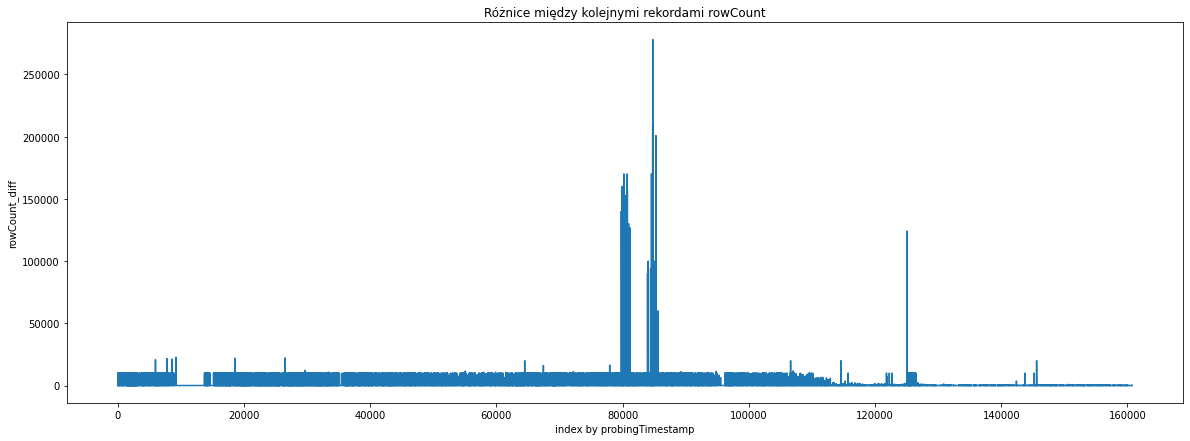

In [ ]:
df['rowCount_diff'] = df.sort_values('probingTimestamp').rowCount.diff()

# interesuje nas zmiana bezwględna 
df.rowCount_diff = df.rowCount_diff.abs()

plt.figure(figsize = (20,7))
sns.lineplot(data=df.rowCount_diff).set(title='Różnice między kolejnymi rekordami rowCount', 
                                        xlabel='index by probingTimestamp')
plt.show()

In [ ]:
df.rowCount_diff.describe()


count    160734.000000
mean        554.870314
std        6672.993920
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max      277960.000000
Name: rowCount_diff, dtype: float64

Tendecja zmiany rowCount w kolejnych seriach czasowych jest widoczna na powyższym wykresie. Istnieją punkty, które wyróżniają się wartością spośród innych. Są one umiejscowione w ok. połowie serii czasowej, w miejscu, gdzie na jednym z poprzednich wykresów zaważalny był znaczący spadek wartości w kolumnie *rowCount*. **Powyższy wykres dobrze pokazuje wyróżniające się spośród ogółu zmiany, aczkolwiek niemożliwe jest na nim dostrzeżenie wiekszych szczegółow.**

Weźmiemy pod uwagę tylko punkty z przedziału, w którym znajduje się większość rekordów.

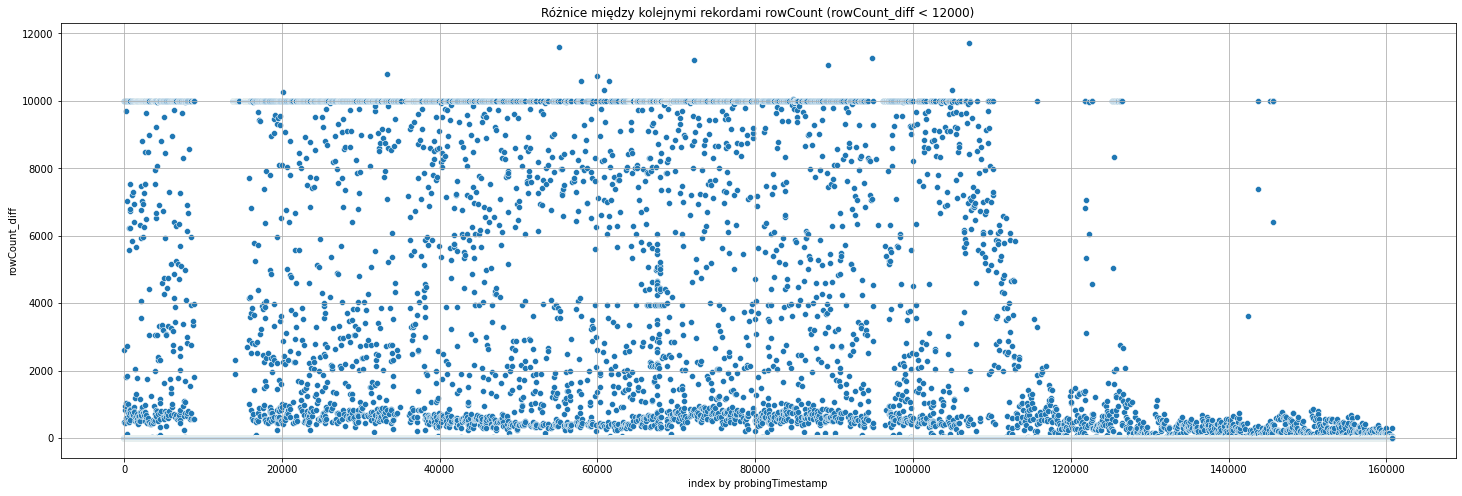

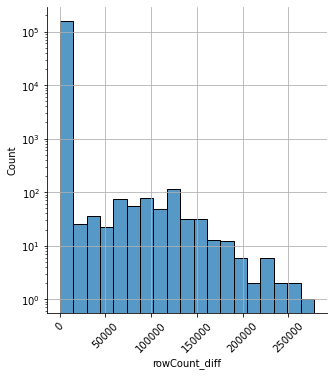

In [ ]:

# wykres rozproszony
plt.figure(figsize = (25,8))
sns.scatterplot(data=df[(df['rowCount_diff'] > -2_000) & (df['rowCount_diff'] < 12_000)].
                rowCount_diff).set(title='Różnice między kolejnymi rekordami rowCount (rowCount_diff < 12000)', 
                                   xlabel='index by probingTimestamp')
plt.grid()


# histogram rozkładu punktów
sns.displot(df.rowCount_diff).set(yscale='log', xlabel='rowCount_diff')
plt.xticks(rotation=45)
plt.grid()


In [ ]:
print(df[(df['rowCount_diff'] > -2_000) & (df['rowCount_diff'] < 12_000)].rowCount_diff.describe())
print( len(df[(df['rowCount_diff'] > -2_000) & (df['rowCount_diff'] < 12_000)]) / len(df))

count    160172.000000
mean        201.092519
std        1313.895072
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max       11726.000000
Name: rowCount_diff, dtype: float64
0.9964973403428002


### **Widoczne informacje nt. zmiany rowCount pomiędzy kolejnymi rekordami (wg. serii czasowej):**
* Po ograniczeniu osi OY wykresu widoczne jest zawężenie występowania znacznej częsci rekordów kolumny rowCount między wartościami [0; 10000]. 
* Gęstość występowania rekordów znacznie rośnie na granicach przedziału. Punkty układają się w tych miejscach wręcz w ciągłą prostą. Należy też zauważyć, że od pewnego momentu wariancja w rekordach znacznie maleje - od indeksu ok 110 tyś. Zmiany w tej części są bardzo stałe
* średnia wartość w zbiorze wynosi ok. 200, jak też widać na wykresie rozproszonym na tej wysokości osi OY wystepuje duże zagęszczenie punktów.
* Przez częsc rekordów, wartość rowCount wydaje się mieć stałą zmianę (indeksy na wykresie w przedziale [10000; 17000])
* Wszystkie kwantyle dla rozkładu przyjmują wartości równe zero

Wyświetlenie statystyk pokazuje nam też, że **aż 99,6% rekordów leżało w dokładniej przenalizowanym przez nas zakresie**.

##Dokładniejsza analiza obszaru wolnego od zmian w kol. rowCount_diff

Dostosowuje zakres indeksów oraz kolumny *rowCount_diff* w celu dostrzeżenia zachowania serii w tej części.

rowCount_diff
0.0      11508
556.0        3
827.0        2
522.0        2
663.0        2
996.0        1
745.0        1
756.0        1
777.0        1
814.0        1
dtype: int64

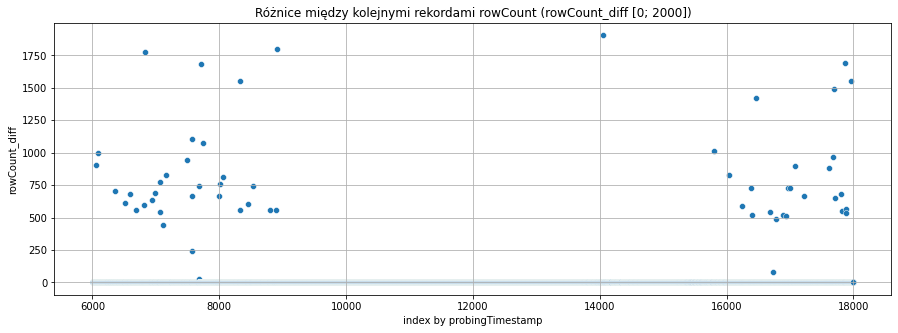

In [ ]:
plt.figure(figsize = (15,5))
sns.scatterplot(data=df[(df['rowCount_diff'] < 2000) & (df.index >6_000) & (df.index < 18_000)].
                rowCount_diff).set(title='Różnice między kolejnymi rekordami rowCount (rowCount_diff [0; 2000])', 
                                   xlabel='index by probingTimestamp')
plt.grid()

df.query("(rowCount_diff < 2000) & (index >6_000) & (index < 18_000)").value_counts('rowCount_diff').head(10)

Punkty w tej części układają się w idelanie prostą linię. **Prawie wszystkie rekordy w tym przedziale czasu miały jedną wartość - równą 0**. Oznacza to, że prawie wszystkie wartości kolumny pozostawały w tej części niezmienne. **Widać też, że punkty na wysokości zera pojawiają się także poza tym charakterystycznym interwałem czasu wyróżniającym się stałą zmianą/jej brakiem w kolumnie *rowCount*.** 

In [ ]:
df.value_counts('rowCount_diff').head(20)

rowCount_diff
0.0         154122
10000.0       2205
130000.0        50
120000.0        50
110000.0        44
80000.0         41
90000.0         41
70000.0         40
3936.0          30
60000.0         29
100000.0        26
140000.0        23
50000.0         21
150000.0        18
40000.0         17
20000.0         15
30000.0         12
6064.0          10
556.0           10
681.0            8
dtype: int64

**Obserwacje:**
* Pierwsze dwie wartości pod względem częstotliwości występowania są to wartości graniczne 'przedziału', który to był juz wspomniany 2 wykresy wyżej. Obserwacja więc była słuszna. 
* Prawie wszystkie z kilkunastu najczęściej występująych w tej kolumnie wartości są krotnościami dziesiątki
* **wartość zerowa w kolumnie rowCount_diff występuje aż w ponad 95% wszystkich rekordów w ramce**. 

# Preparacja kolumny z różnicami w serii czasowej
W celu lepszego zobrazowania ciągłości serii czasowej możemy utworzyć dodatkową kolumnę z interwałami oraz stworzyć na jej  podstawie wykres. Utworzona kolumna posłuży nam później przu użyciu funkcji.

In [ ]:
df['interval'] = df.probingTimestamp.sort_values().diff()
df.interval
#sns.scatterplot(x='interval', y='probingTimestamp', data=df)

0        0 days 00:00:57.444000
1        0 days 00:00:59.660000
2        0 days 00:00:59.523000
3        0 days 00:00:59.533000
4        0 days 00:01:00.550000
                  ...          
160730   0 days 00:01:00.614000
160731   0 days 00:01:00.480000
160732   0 days 00:00:59.540000
160733   0 days 00:00:59.514000
160734   0 days 00:01:00.440000
Name: interval, Length: 160735, dtype: timedelta64[ns]

Powstała kolumna jest typu *timedelta64*. W celu zobrazowania czasów trwania interwałów na wykresie można np.wyekstraktować poszczególne jednostki czasu kolejnych przerw pomiędzy seriami czasowymi.

# Implementacja funkcji w celu diagnozny potecjalnych problemów z jakością danych

Stworzone zostaną dwie funkcje: 
* funkcja do kreślenia czasu trwania (w sekundach) interwału pomiędzy kolejnymi pomiarami. 
* funkcja do wyszukiwania zduplikowanych rekordów.



### **Funkcja do wyświetlania interwałów czasowych pomiędzy kolejnymi seriami czasowymi.** 
Umożliwi ona potencjalne dostrzeżenie miejsc, w których może występować przerwanie ciąglości serii.

In [ ]:
from pandas.core.frame import DataFrame

def interval_plotter(dataframe:pd.DataFrame, timedelta_col:str):

  days = dataframe[timedelta_col].dt.components['days']
  hrs = dataframe[timedelta_col].dt.components['hours']
  mins = dataframe[timedelta_col].dt.components['minutes']
  secs = dataframe[timedelta_col].dt.components['seconds']
  millisecs = dataframe[timedelta_col].dt.components['milliseconds']
  
  dataframe['interval_duration'] = 86400*days +3600*hrs + 60*mins + secs + 0.001*millisecs

  # wykres interval_duration
  g = plt.figure(figsize = (20,7))
  g = sns.lineplot(x='probingTimestamp', y='interval_duration', data=dataframe).set(title='Przerwy w kolejnych rekordach serii czasowej w [sek]')
  plt.show()

  print(f"\nStatystyki dotyczące długości trwania interwałów serii czasowej\n{dataframe['interval_duration'].describe().round(2)}\n")

  # histogram dla części interwałów w serii czasowej
  df.interval_duration.plot(kind='hist',
                            bins=1_000, 
                            log=True, 
                            figsize=(15,5), 
                            xlim=(1, 2000), 
                            title='Histogram dla interwałów <2000 [sek]',
                            xlabel='interval_duration [sec]',
                            )
  plt.show()



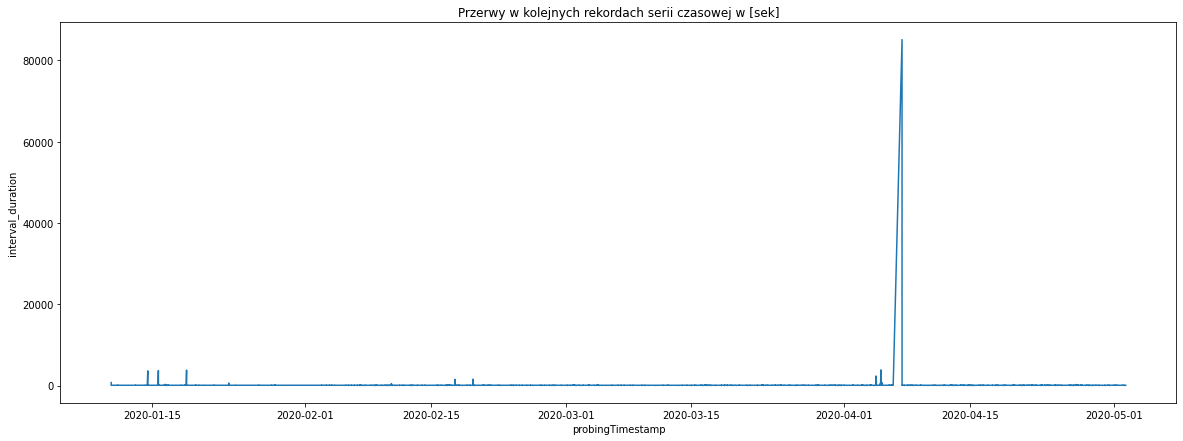


Statystyki dotyczące długości trwania interwałów serii czasowej
count    160734.00
mean         60.69
std         213.19
min           0.00
25%          59.51
50%          59.77
75%          60.51
max       85122.74
Name: interval_duration, dtype: float64



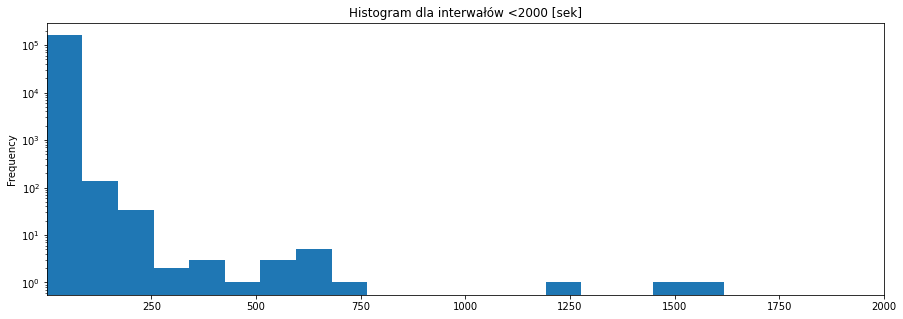

In [ ]:
interval_plotter(df, 'interval')

Wykorzystując funkcję rysującą wykres interwałów czasowych pomiędzy kolejnymi pomiarami **możliwe jest łatwe dostrzeżenie punktów odstających od reszty. W tych miejscach seria jest nieciągła.** Szczególnie widoczna jest przerwa ukazana wcześniej na wykresie rozproszonym z dnia 2020-04-06

Możemy spojrzeć na statystyki długości trwania interwałów. W celu zwiększenia klarowności wykresu odrzuciłem wartości graniczne oraz zastosowałem skalę loagrytmiczną. **Wnioski**:
* **Widać, że rekordy były aktualizwoane średnio co 60 sekund.** 
* Mediana interwałów (kwantyl 50%) jest bardzo zbliżona do średniej co świadczy o występowaniu rozkładu normalnego w ich wartości
* Należy też zwrócić uwagę na samo podobieństwo wykresu do rozkładu normalnego (w tym wypadku jednostronnego, co wynika z nieujemnej zmiennej czasowej). Występowanie tego podobieństwa może świadczyć o błędzie statystycznym w przerwie między pobraniem kolejnych wartości rowCount.

### **Funkcja do wykrywania duplikatów**
Informować będzie o potencjalnym wystąpieniu zduplikowanych rekordów, pokaże ich ilość, wyświetli przykładowe wartości oraz pokaże ich rozłożenie na tle całej serii.

In [ ]:
def duplicate_search(dataframe:pd.DataFrame):

  duplicates = dataframe[dataframe.duplicated()]
  no_duplicates = len(duplicates)
  duplicates_indexes = list(duplicates.index)

  if len(duplicates) != 0:
    print(f'Liczba duplikatów: {no_duplicates}')
    print(f'\nIndeksy zduplikowanych rekordów {duplicates_indexes}')
    print(f'\nPrzykładowe zduplikowane rekordy\n {duplicates.head()}\n')

    plt.figure(figsize = (25,7))
    #plt.style.use("default")
    sns.lineplot(data=dataframe.sort_values('probingTimestamp').duplicated().astype(float)).set(xlabel='index by probingTimestamp',
                                                                                                ylabel='Wyst. duplikatu',
                                                                                                yticks=[0, 1],
                                                                                                title="Duplikaty w serii czasowej"
                                                                                                )
    plt.show()

  else: print('W danych brak jest duplikatów\n')

Używam 'surowego' dataseta wgranego na początku notatnika.

Liczba duplikatów: 222

Indeksy zduplikowanych rekordów [8733, 8947, 20515, 37395, 37568, 38205, 39072, 39109, 39237, 40233, 40250, 40267, 41374, 41968, 42079, 42676, 42792, 43148, 43386, 43724, 44118, 44329, 44866, 45454, 46152, 46423, 46619, 47898, 48245, 48675, 48709, 48754, 49611, 49835, 50454, 50590, 52003, 52159, 53121, 53369, 53960, 54679, 55160, 55742, 55778, 55947, 56979, 57652, 57913, 58092, 59208, 61821, 64315, 64469, 64694, 65499, 65935, 66098, 66956, 67354, 68654, 68691, 69243, 70276, 70357, 70451, 71724, 71730, 72174, 73093, 73094, 73445, 74506, 74681, 75072, 75233, 75495, 76302, 76736, 77005, 77213, 78605, 78670, 79118, 79199, 79439, 80081, 80100, 81163, 81253, 81708, 82127, 83315, 83571, 83775, 84240, 84683, 85135, 85195, 85918, 87185, 87473, 87881, 88111, 89479, 91003, 91537, 91881, 92227, 92943, 92997, 93340, 93807, 94482, 94637, 94886, 95149, 95459, 96201, 96395, 97851, 98483, 99074, 99692, 99792, 99960, 101561, 102245, 102362, 103874, 104263, 108599, 109278, 110339,

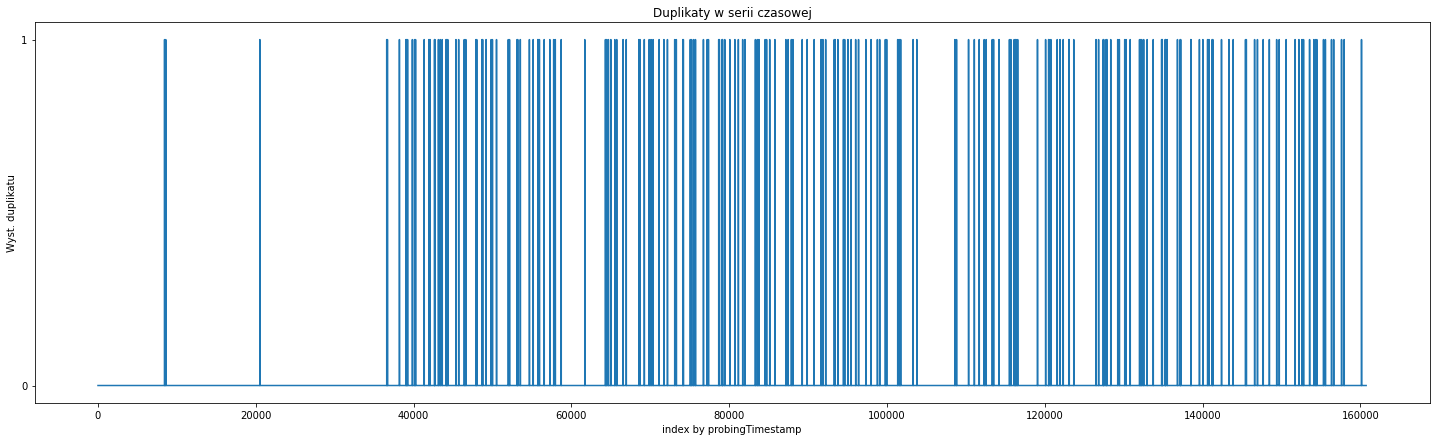

In [ ]:
duplicate_search(df_raw)

Powyższy wykres pokazuje nam rozmieszczenie duplikatów na przestrzeni wszystkich rekordów. Gdzie każda jedna pozioma kreska odpowiada wystąpieniu duplikatu. Możliwe to było dzięki mapowaniu wartości logicznych. Dane zostały posortowane względem serii czasowej. **Dostrzec możemy:**
* mniejszą częstotliwośc występowania duplikatów dla częsci pierwszych rekordów (do ok. indeksu 38 tyś.) Od mniej więcej tego momentu duplikaty zaczynają pojawiać się znacznie częściej, wręcz regularnie. 
Możemy postawić hipotezę, że większa ilość danych sprzyja częstszemu pojawianiu się zduplikowanych rekordów. 

# Podsumowanie

W notatniku przedstawiona była analiza jakościowa, analiza zachowania rekordów w funkcji czasu oraz zmiana samej serii czasowej.
> Wstępne zapoznanie się z charakterystyką danych pozwoliło na późniejszą dogłębną analizę zmian w ramce danych m.in w próbkowaniu samej kolumny z czasem. 

> Przedstawiono zachowanie odpowiadającej serii czasowej kolumnie rowCount. Skutkowało to dostrzeżeniem kilku nietypowych zachowań obserowanych w zmianch kolumny rowCount, wyznaczono m.in. jej średnią zmianę, przedział i wartość, dla której zmiana zachodziła najczęściej

> Utworzono i zaimplementowano funkcję, która pomagać może w wykrywaniu przerw w ciągłości odczytu serii czasowej. Funkcja zadziałała prawidłowo.  

> Zaimplemetnowano funkcję odpowiadają za ew. wykrywanie duplikatów w zbiorze danych oraz wyświetlającą o nich informacje tj.: ich ilość, indeksy, rozmieszczenie rekordów.









